# Overview
### Due Dec 14th

##Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate but EACH must turn in a copy of the homework.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. Please leave the audio loaded when submitting the homework.

YOU MUST SUBMIT EACH HOMEWORK, even if your partner submits! Upload your completed assignment on moodle.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
import torch

# PCA with a Linear Autoencoder


In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras.

Let's create a sin+noise signal to use as input to our network:

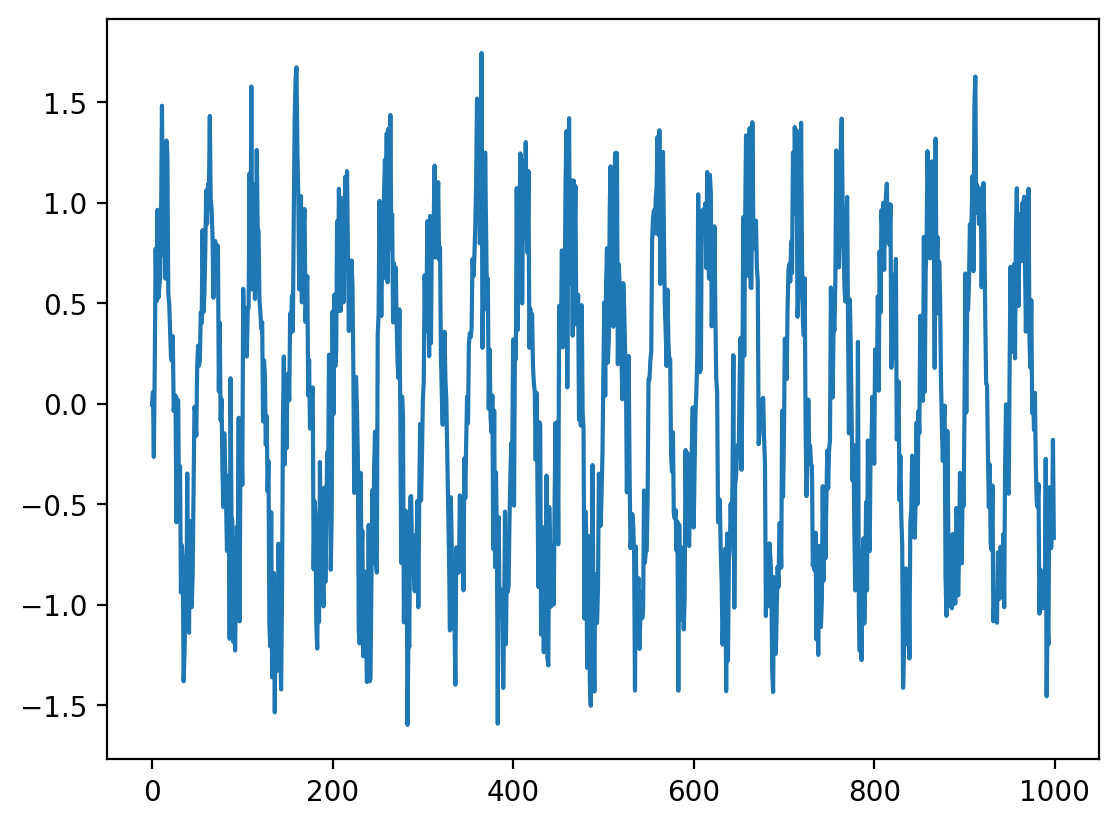

In [3]:
f0 = 200
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers.

This neural network is implemented in TensorFlow.

Please review the code cells below, and answer the questions that follow.

In [4]:
# Initialize parameters
n_inputs = xmat.shape[0]
n_hidden = 2
learning_rate = 0.01
n_iterations = 10000

# Convert data to PyTorch tensors
X_train = torch.tensor(xmat.T, dtype=torch.float32)
X_test = X_train.clone()

# Initialize weights
W = torch.empty(n_inputs, n_hidden, dtype=torch.float32, requires_grad=True)
torch.nn.init.trunc_normal_(W, std=0.1)

# Training loop
optimizer = torch.optim.Adam([W], lr=learning_rate)


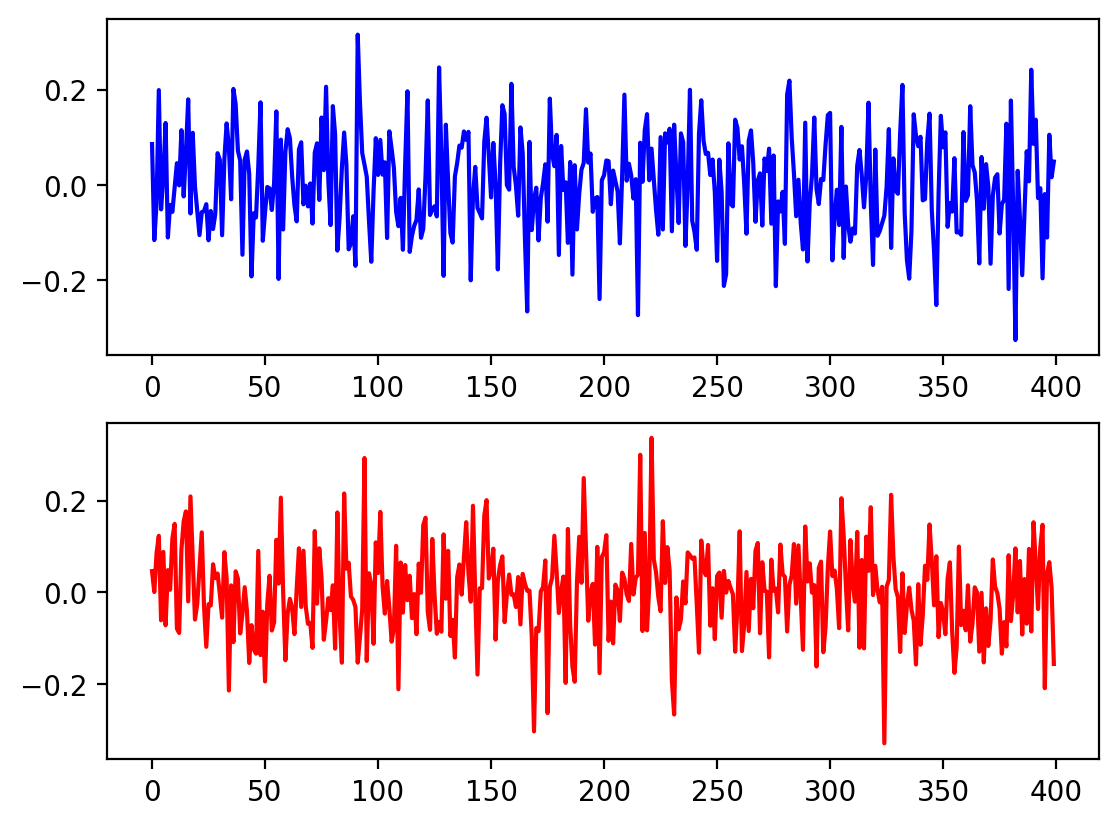

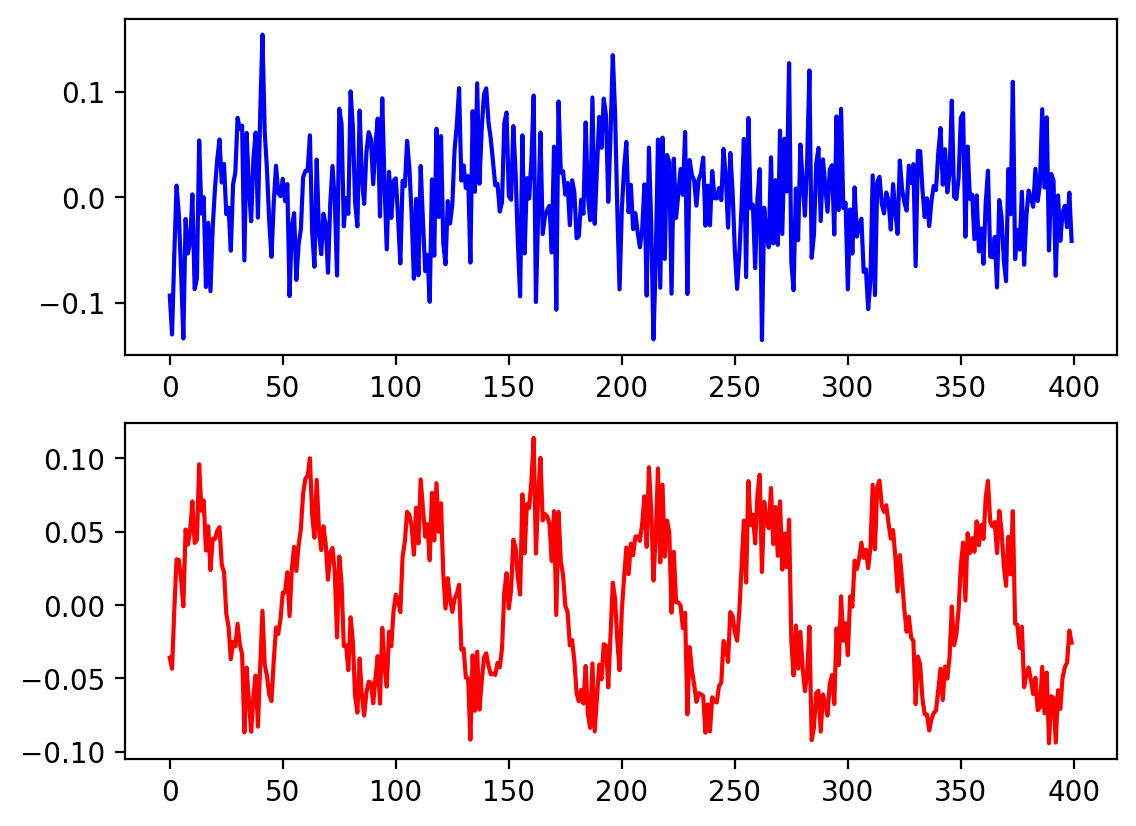

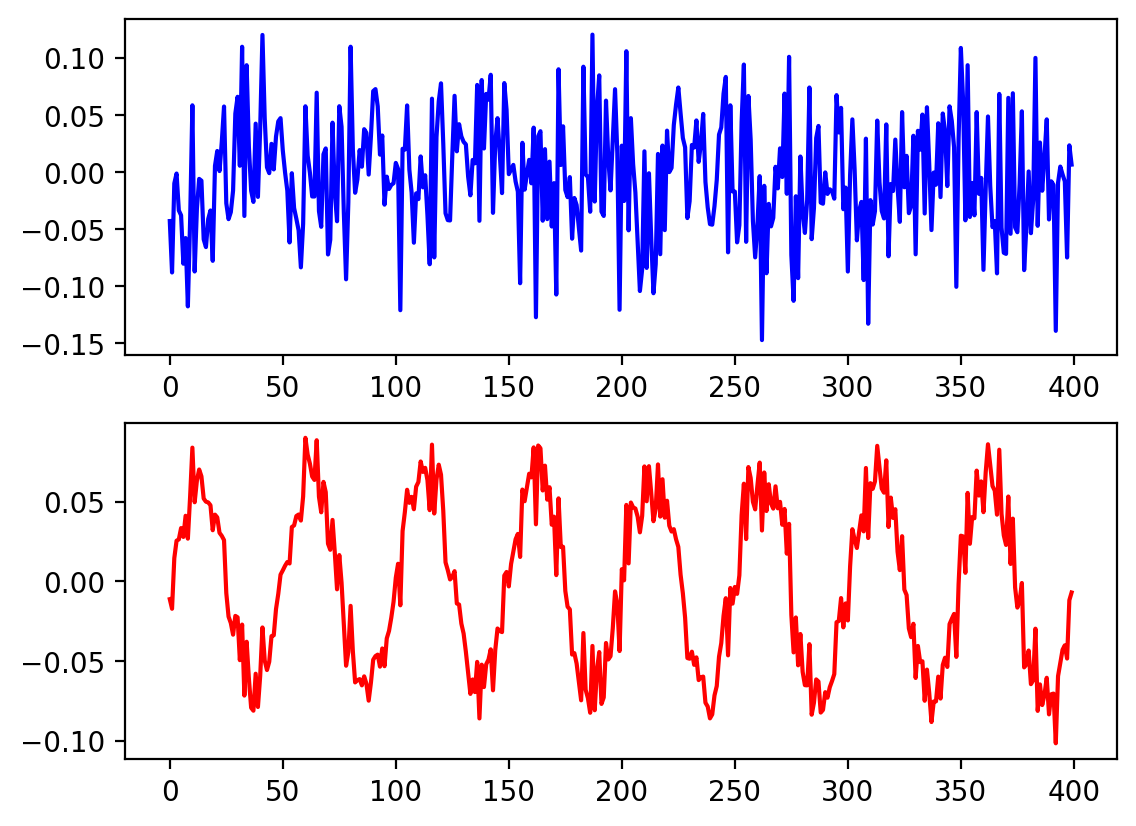

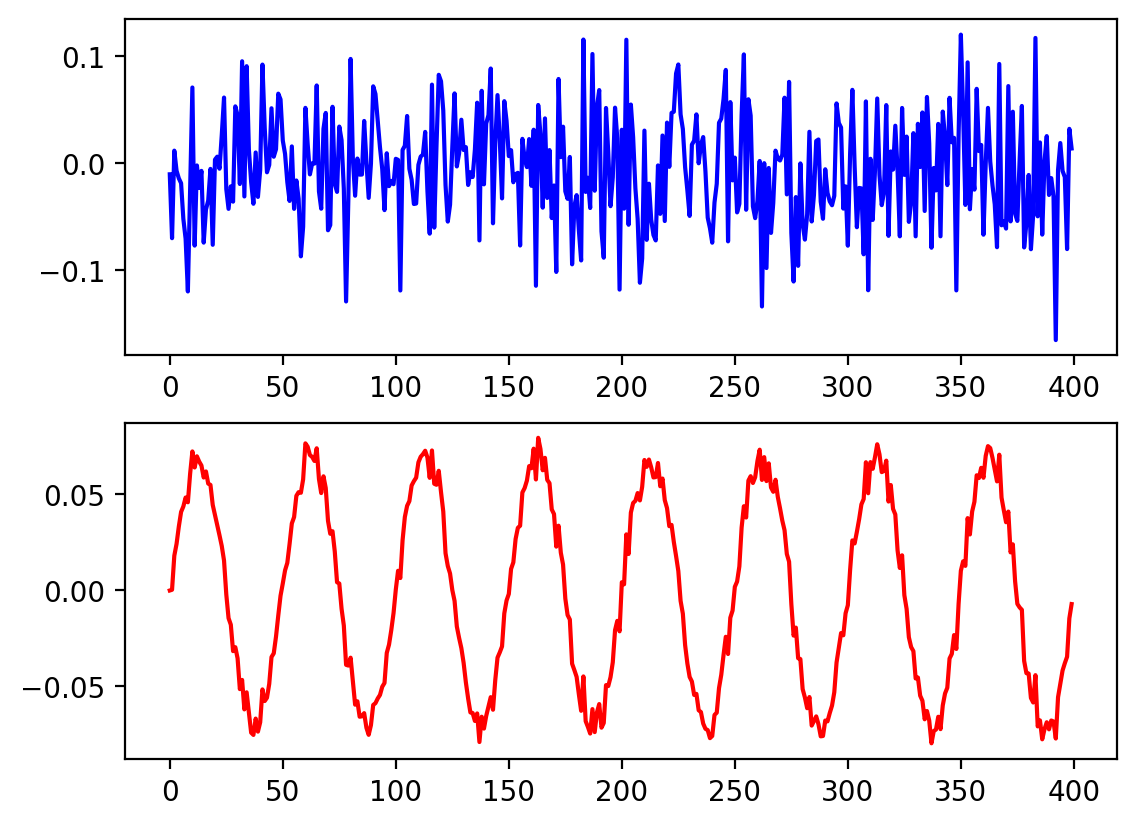

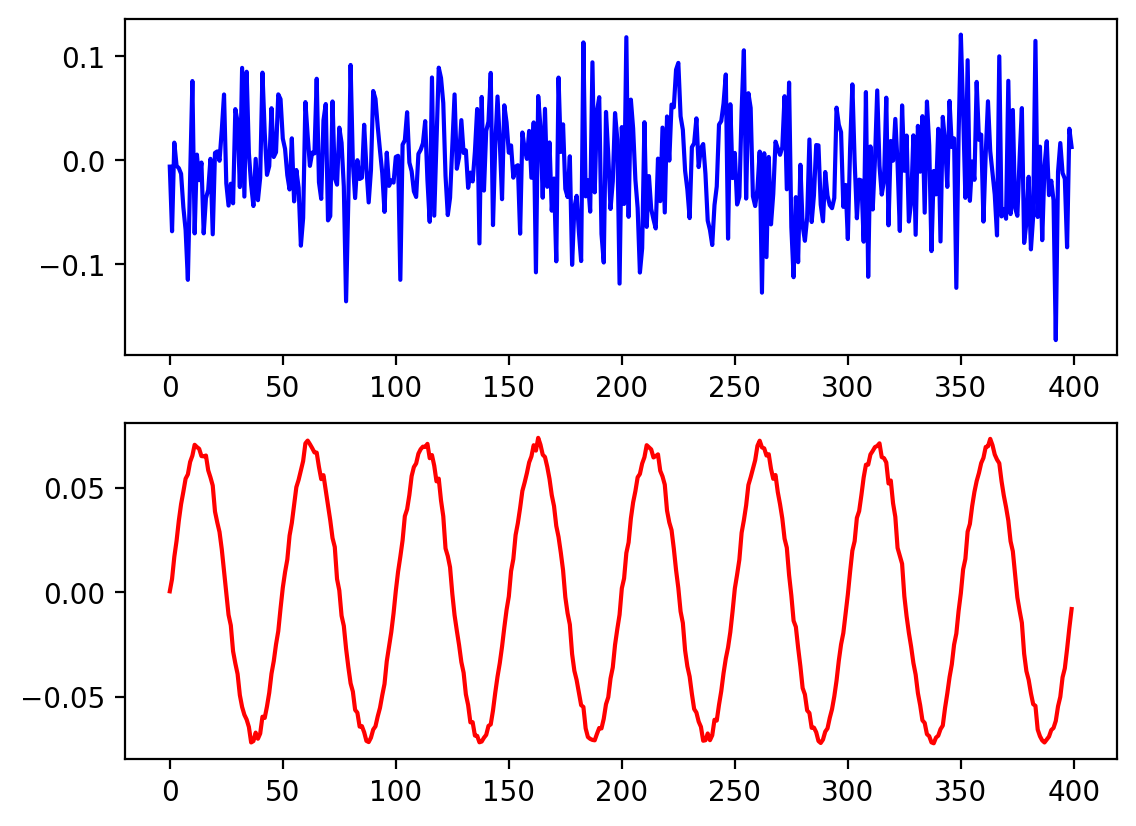

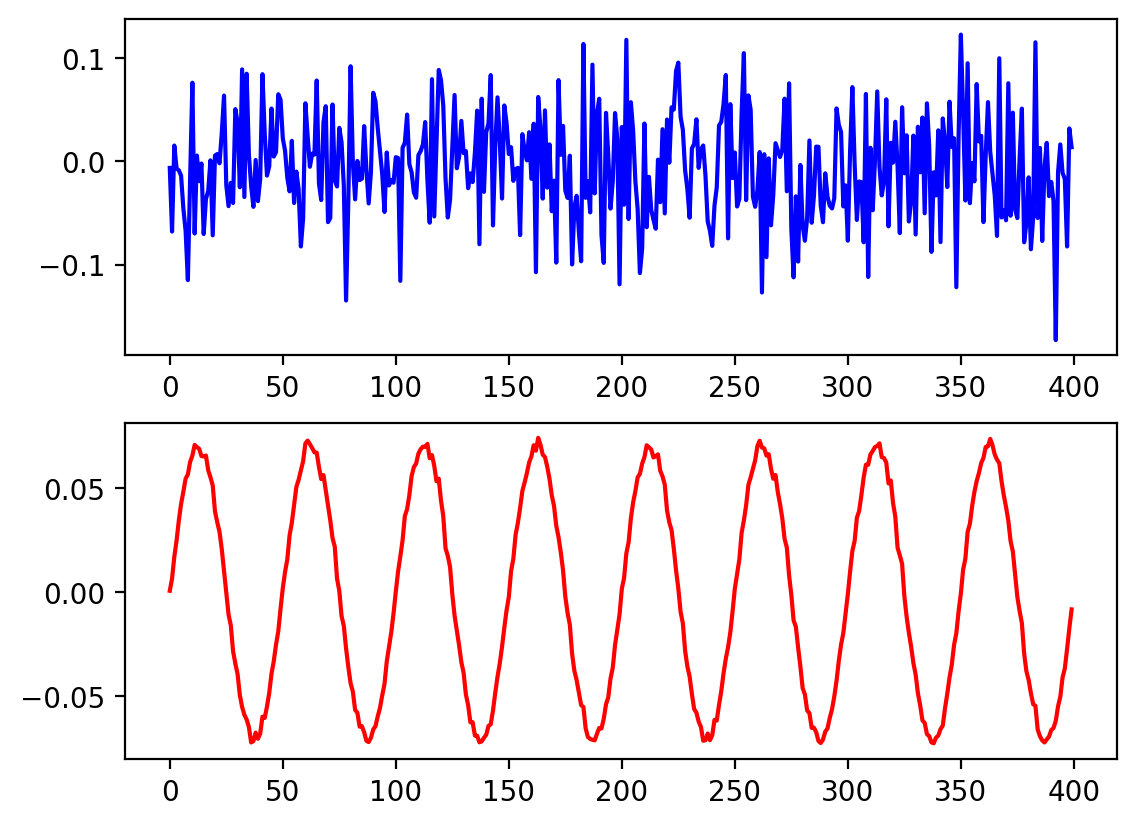

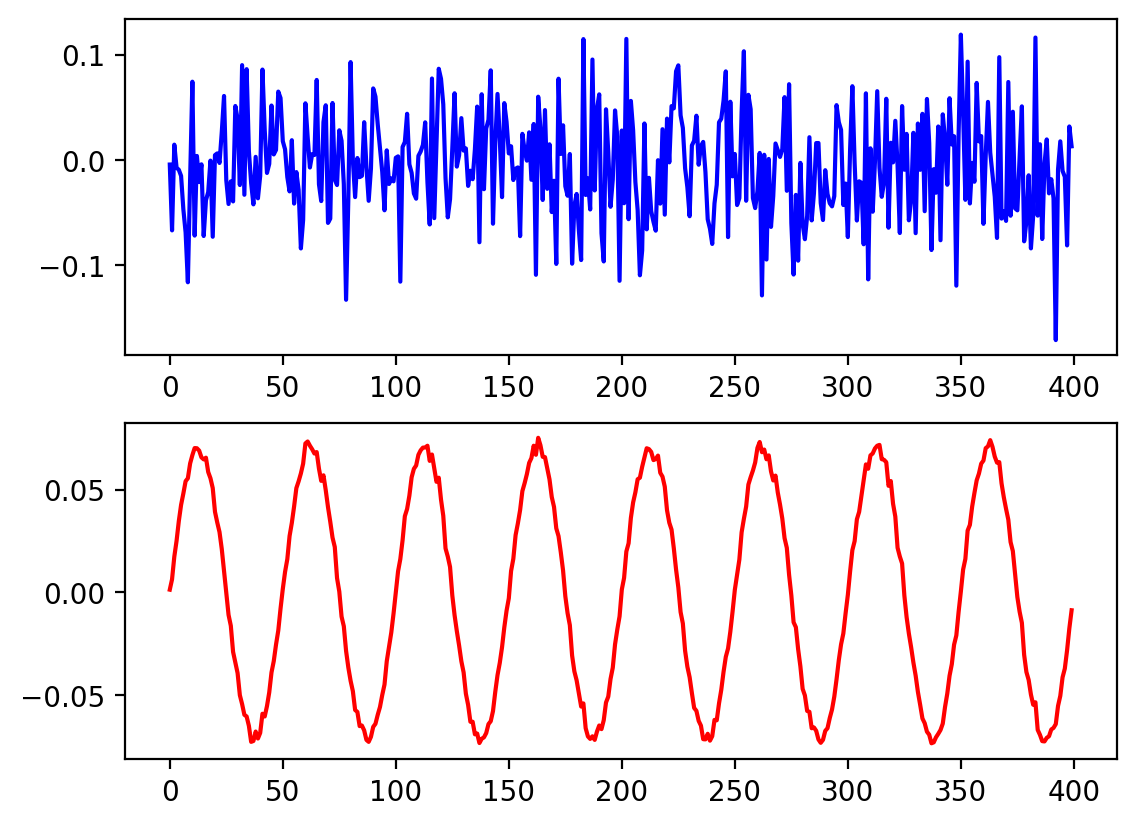

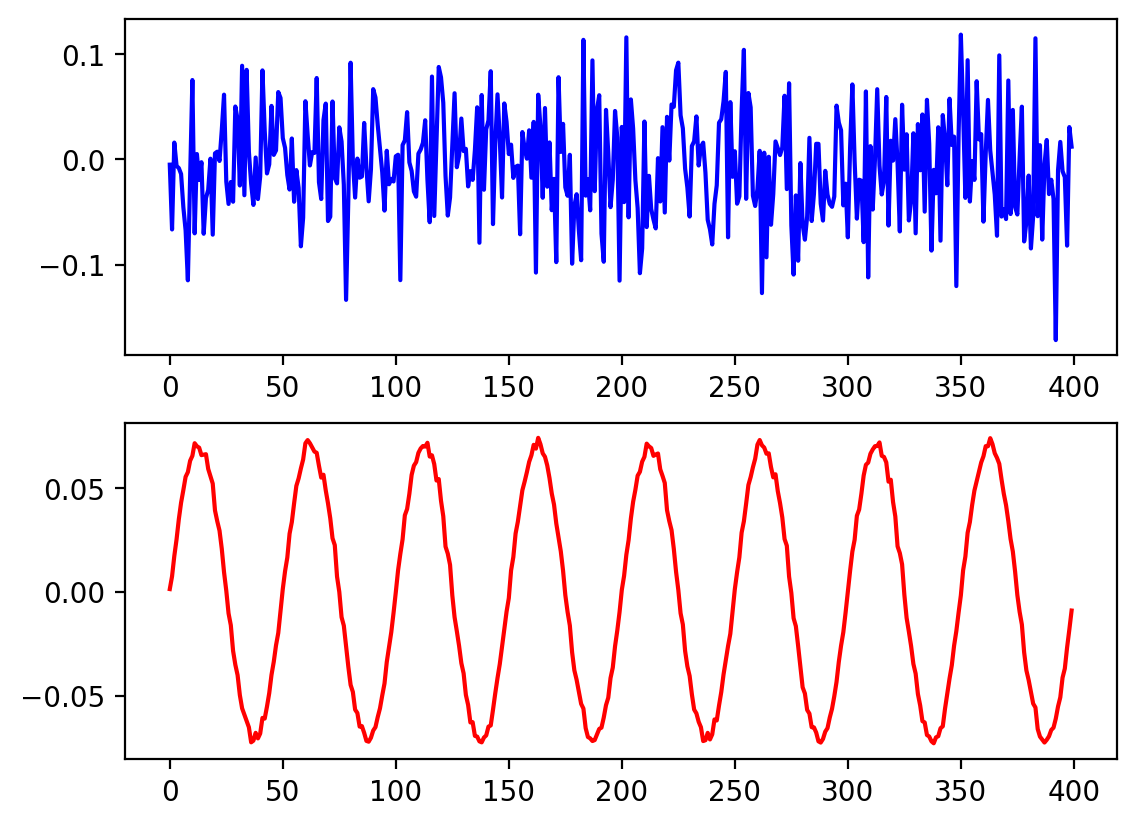

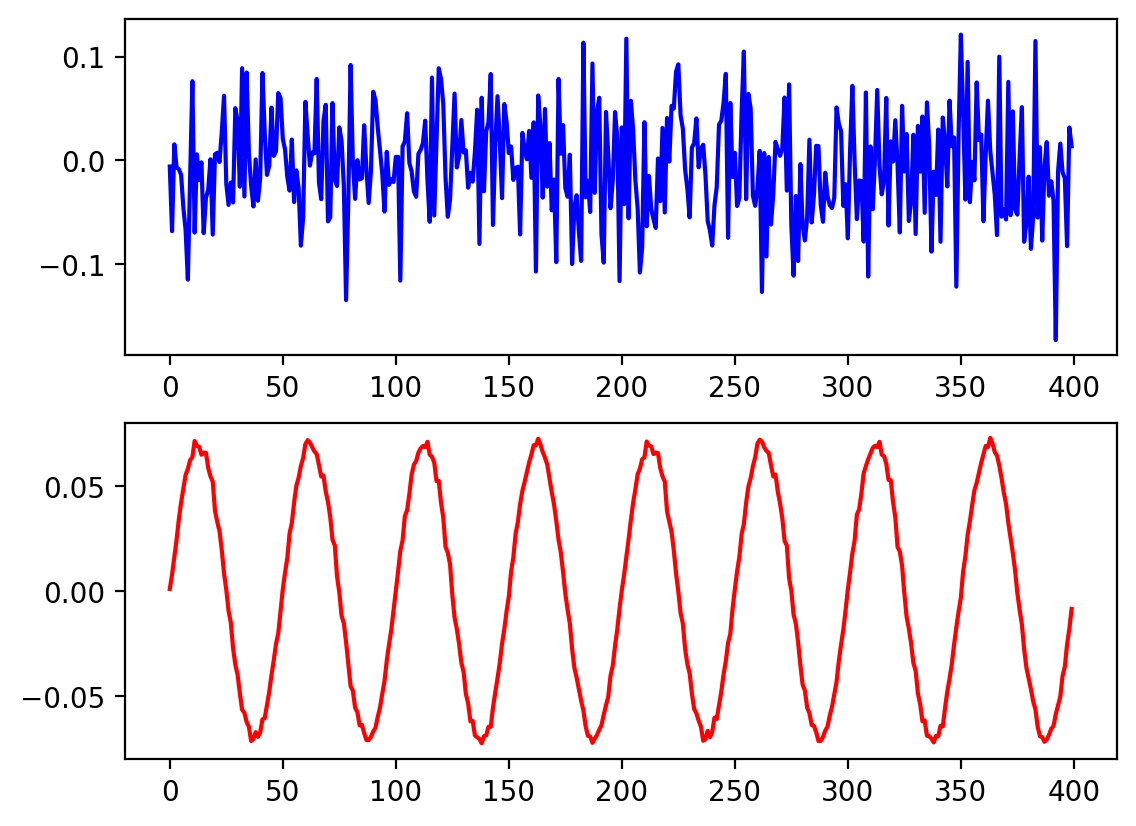

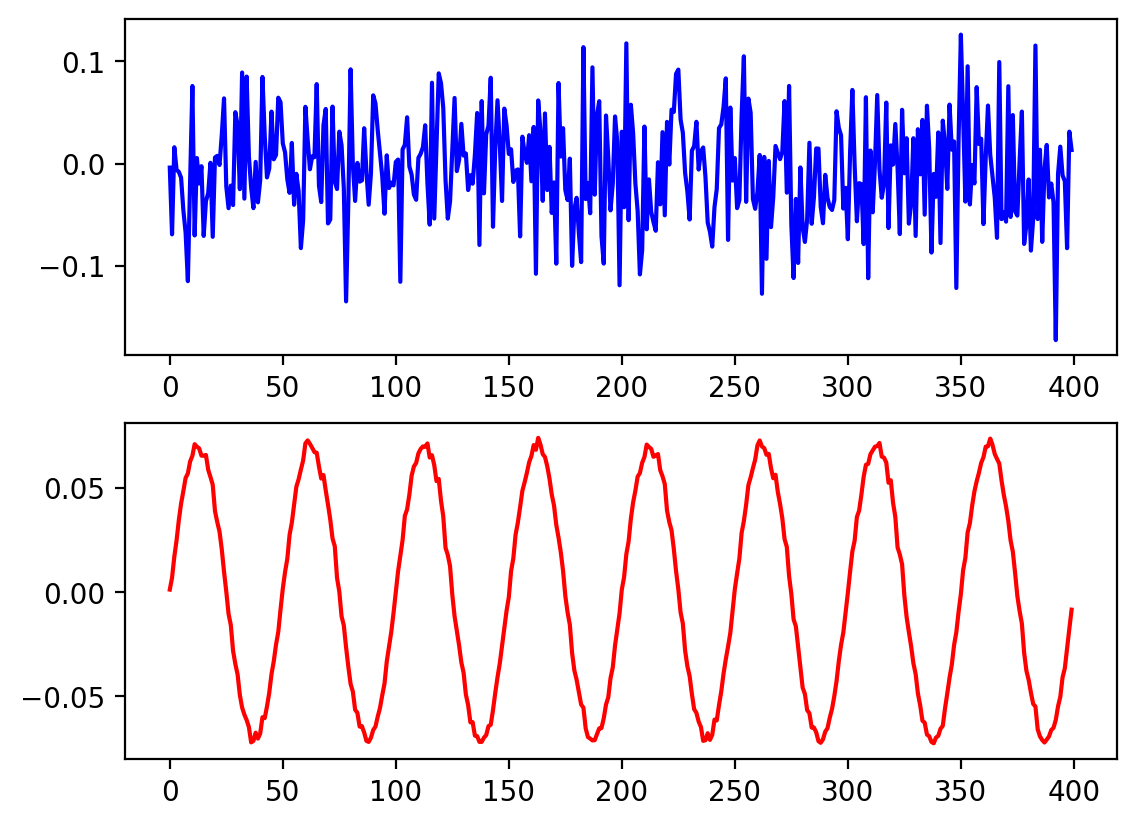

Done with training


In [5]:
col = ['b', 'r', 'g', 'c', 'm', 'y', 'k']

for iteration in range(n_iterations):
    # Forward pass
    hidden = torch.matmul(X_train, W)
    outputs = torch.matmul(hidden, W.T)
    reconstruction_loss = torch.mean((outputs - X_train) ** 2)

    # Backward pass
    optimizer.zero_grad()
    reconstruction_loss.backward()
    optimizer.step()

    # Visualization every 1000 iterations
    if iteration % 1000 == 0:
        with torch.no_grad():
            W_val = W.detach().numpy()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden, 1, k + 1)
            plt.plot(W_val[:, k], col[k % len(col)])
        plt.show(block=False)
        plt.pause(0.001)

# Get codings
with torch.no_grad():
    codings_val = torch.matmul(X_test, W).numpy()

print("Done with training")


##### Question 1 (10 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

``` Your response here ```<br>
<b>What is an autoencoder?</b>

An autoencoder is a type of neural network that is trained to learn efficient representations of input data, typically for dimensionality reduction. It consists of two main parts:

1. Encoder: This part compresses the input data into a lower-dimensional representation called the "latent space" or "bottleneck".
2. Decoder: This part reconstructs the original input data from the latent space representation.

The autoencoder is trained to minimize the difference between the input data and its reconstruction. This forces the network to learn the most important features of the input data in order to reconstruct it accurately.

<b>What would happen (ideally) if you pass a portion of signal x through the trained network?</b>

Ideally, if you pass a portion of signal x through a trained autoencoder network, the network would reconstruct the original signal x with minimal error. This is because the autoencoder has learned to capture the essential features of the signal during training.

In simpler terms: Imagine you have a complex image. The encoder would compress it into a smaller, simpler representation. The decoder would then take this simpler representation and try to recreate the original image. A well-trained autoencoder should be able to recreate the image with high accuracy.

In the context of the code: The autoencoder is being trained on the signal 'x' which is a sin wave with added noise. When a portion of 'x' is passed through the trained network, it will try to reconstruct the original sin wave without the noise, effectively denoising the signal.

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

``` Your response here ```
1. Shape of n_inputs:

* n_inputs is assigned the value of xmat.shape[0].
* xmat was created using the buffer function which returns a transposed array of signal frames.
* Therefore, xmat.shape[0] represents the number of samples within each frame of the signal, which is 400 (as defined in the buffer function).

2. Definition of X_train:

* X_train is created from xmat by transposing it and converting it into a PyTorch tensor.
* This means that each row of X_train represents a single frame of the signal, containing 400 samples.
* Each column of X_train represents a specific feature or time point within that frame.

<b>What is being passed to the input layer?</b>

During a single forward pass, a single row of X_train is passed to the input layer of the network. This row represents a single window/frame of the signal x, containing 400 samples (as defined in the buffer function).

In essence, each input to the network is a 400-sample segment of the original signal.

Why this approach?

This framing approach is common in signal processing and allows the network to learn temporal dependencies within the signal. By looking at small windows of the signal at a time, the network can learn patterns and features that evolve over time.

##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

``` Your response here ```

<b>What variable(s) are used to represent the network weights?</b>

The network weights are represented by the variable W in the code.

* ` W = torch.empty(n_inputs, n_hidden, dtype=torch.float32, requires_grad=True)`

This line creates a PyTorch tensor named W to store the weights.

* `n_inputs`: Represents the number of input features, which is 400 in this case (the size of the input window).
* `n_hidden`: Represents the number of neurons in the hidden layer, which is 2 in this case.

Therefore, W is a matrix with dimensions 400x2, representing the connections between the input layer (400 features) and the hidden layer (2 neurons).

<b>How are these weights initialized prior to training?</b>

The weights are initialized using a truncated normal distribution with a standard deviation of 0.1. This is done using the following line of code:

* `torch.nn.init.trunc_normal_(W, std=0.1)`

Truncated Normal Distribution: This distribution is similar to a normal distribution but values that fall outside a specified range are "truncated" (removed). This helps prevent extreme weight values during initialization, which can lead to instability during training.

Standard Deviation (std=0.1): The standard deviation controls the spread of the distribution. A smaller standard deviation (like 0.1) results in weights that are initialized closer to zero.

<b>Why is initialization important?</b>

Proper weight initialization is crucial for successful training of neural networks. If weights are initialized with very large or very small values, it can hinder the network's ability to learn effectively. Initializing weights with a truncated normal distribution helps ensure that the network starts with a reasonable set of weights and can converge to a good solution during training.

##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

``` Your response here ```<br>
<b>What is being minimized in the reconstruction loss?</b>

The reconstruction loss is minimizing the difference between the original input data (X_train) and the reconstructed output data (outputs) produced by the autoencoder.

* `reconstruction_loss = torch.mean((outputs - X_train) ** 2)`

This line of code calculates the Mean Squared Error (MSE) between the original and reconstructed data. It essentially measures the average squared difference between each corresponding element in the two datasets.

<b>Why is this helpful?</b>

Minimizing the reconstruction loss is helpful because it forces the autoencoder to learn a compressed representation (in the hidden layer) that can be used to accurately reconstruct the original input data.

Here's why this is beneficial:

1. Feature Extraction: By minimizing the reconstruction error, the autoencoder is encouraged to capture the most important features of the input data in its hidden layer. This is because it needs to preserve enough information to reconstruct the original data as accurately as possible.

2. Dimensionality Reduction: The hidden layer typically has a lower dimensionality than the input data. By forcing the network to reconstruct the input from this lower-dimensional representation, the autoencoder learns a compressed version of the data that retains the most important information.

3. Denoising: In this specific case, where the input signal x contains noise, minimizing the reconstruction loss helps the autoencoder learn to separate the signal from the noise. The network is trained to reconstruct the clean sin wave, effectively denoising the input signal.

In summary, minimizing the reconstruction loss guides the autoencoder to learn a compressed and informative representation of the input data, which can be used for various tasks like dimensionality reduction, feature extraction, and denoising.

##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training?

``` Your response here ```

<b>What is an optimizer?</b>

In the context of machine learning, an optimizer is an algorithm or method used to adjust the parameters (weights and biases) of a neural network during training in order to minimize the loss function.

Think of it like this: the loss function tells us how "bad" the network's predictions are, and the optimizer's job is to find the best set of parameters that make the predictions as "good" as possible (minimize the loss).

<b>How do optimizers work?</b>

Optimizers typically use a form of gradient descent to update the network's parameters. They calculate the gradient of the loss function with respect to the parameters, which indicates the direction of steepest ascent. Then, they update the parameters in the opposite direction (steepest descent) to minimize the loss.

<b>3 Common Optimizers:</b>

1. Stochastic Gradient Descent (SGD): A basic but widely used optimizer that updates the parameters based on the gradient of the loss calculated from a small batch of training data.

2. Adam (Adaptive Moment Estimation): A popular optimizer that combines the benefits of two other optimizers, AdaGrad and RMSProp. It adapts the learning rate for each parameter based on the historical gradients and is known for its efficiency and good performance.

3. RMSprop (Root Mean Square Propagation): An optimizer that addresses the diminishing learning rates problem of AdaGrad by using a moving average of squared gradients to normalize the learning rate.

<b>Which optimizer is used in this AE training?</b>

The optimizer used in this autoencoder training is Adam. You can see it in this line of code:


`optimizer = torch.optim.Adam([W], lr=learning_rate)`

This line creates an Adam optimizer instance and specifies that it should be used to update the weights (W) of the network. The lr argument sets the learning rate, which controls the step size of the parameter updates.

<b>Why Adam?</b>

Adam is a popular choice for many deep learning tasks because it is generally efficient, robust, and requires less hyperparameter tuning compared to other optimizers. In this case, it's a suitable choice for training the autoencoder to minimize the reconstruction loss.

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more significant codings should have smaller variances.

mean:  [-0.09593771 14.162123  ]
variance [0.7770083 0.2676849]


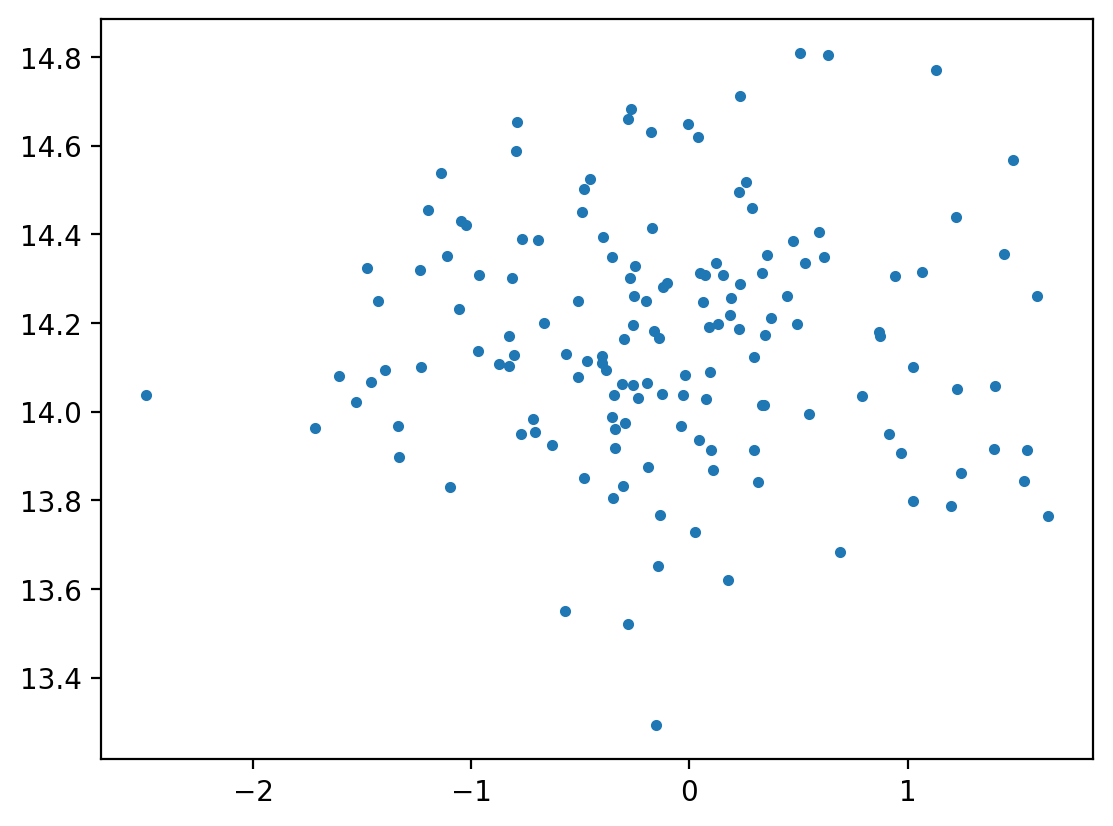

In [6]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

``` Your response here ```<br>
<b>In what way does the autoencoder network function similarly to PCA?</b>

Both autoencoders (AEs) and Principal Component Analysis (PCA) are techniques used for dimensionality reduction, but they achieve it through different approaches. Here's how their functionality is similar:

Dimensionality Reduction: Both AEs and PCA aim to reduce the dimensionality of data by finding a lower-dimensional representation that captures the most important information.

Learning Underlying Structure: Both techniques try to learn the underlying structure of the data by identifying the principal components or features that explain the most variance in the data.

Linear Transformations: In their basic forms, both AEs and PCA perform linear transformations on the data to project it onto a lower-dimensional space. This means they use linear combinations of the original features to create the reduced representation.

Reconstruction: Both techniques can be used to reconstruct the original data from the lower-dimensional representation, although the reconstruction might not be perfect due to information loss during dimensionality reduction.

However, there are key differences:

Linearity: Standard PCA is strictly a linear technique, while AEs can be designed with non-linear activation functions in their hidden layers, allowing them to capture more complex relationships in the data.

Learning Approach: PCA is a mathematical technique that directly calculates the principal components based on the covariance matrix of the data. AEs, on the other hand, are neural networks that learn the lower-dimensional representation through an iterative training process.

Flexibility: AEs are generally more flexible than PCA as they can be designed with different architectures and activation functions to suit specific tasks and data types.

In the context of the code: The autoencoder with a single hidden layer and linear activations is functionally similar to PCA. It learns a linear transformation of the input data to a lower-dimensional space (represented by the hidden layer) and then reconstructs the input from this representation. The weights of the network effectively represent the principal components, and the hidden layer activations correspond to the projections of the data onto these components.

Therefore, in this specific scenario, the autoencoder behaves similarly to PCA in terms of dimensionality reduction and feature extraction.

##### Question 7 - PCA versus AE (20 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network?


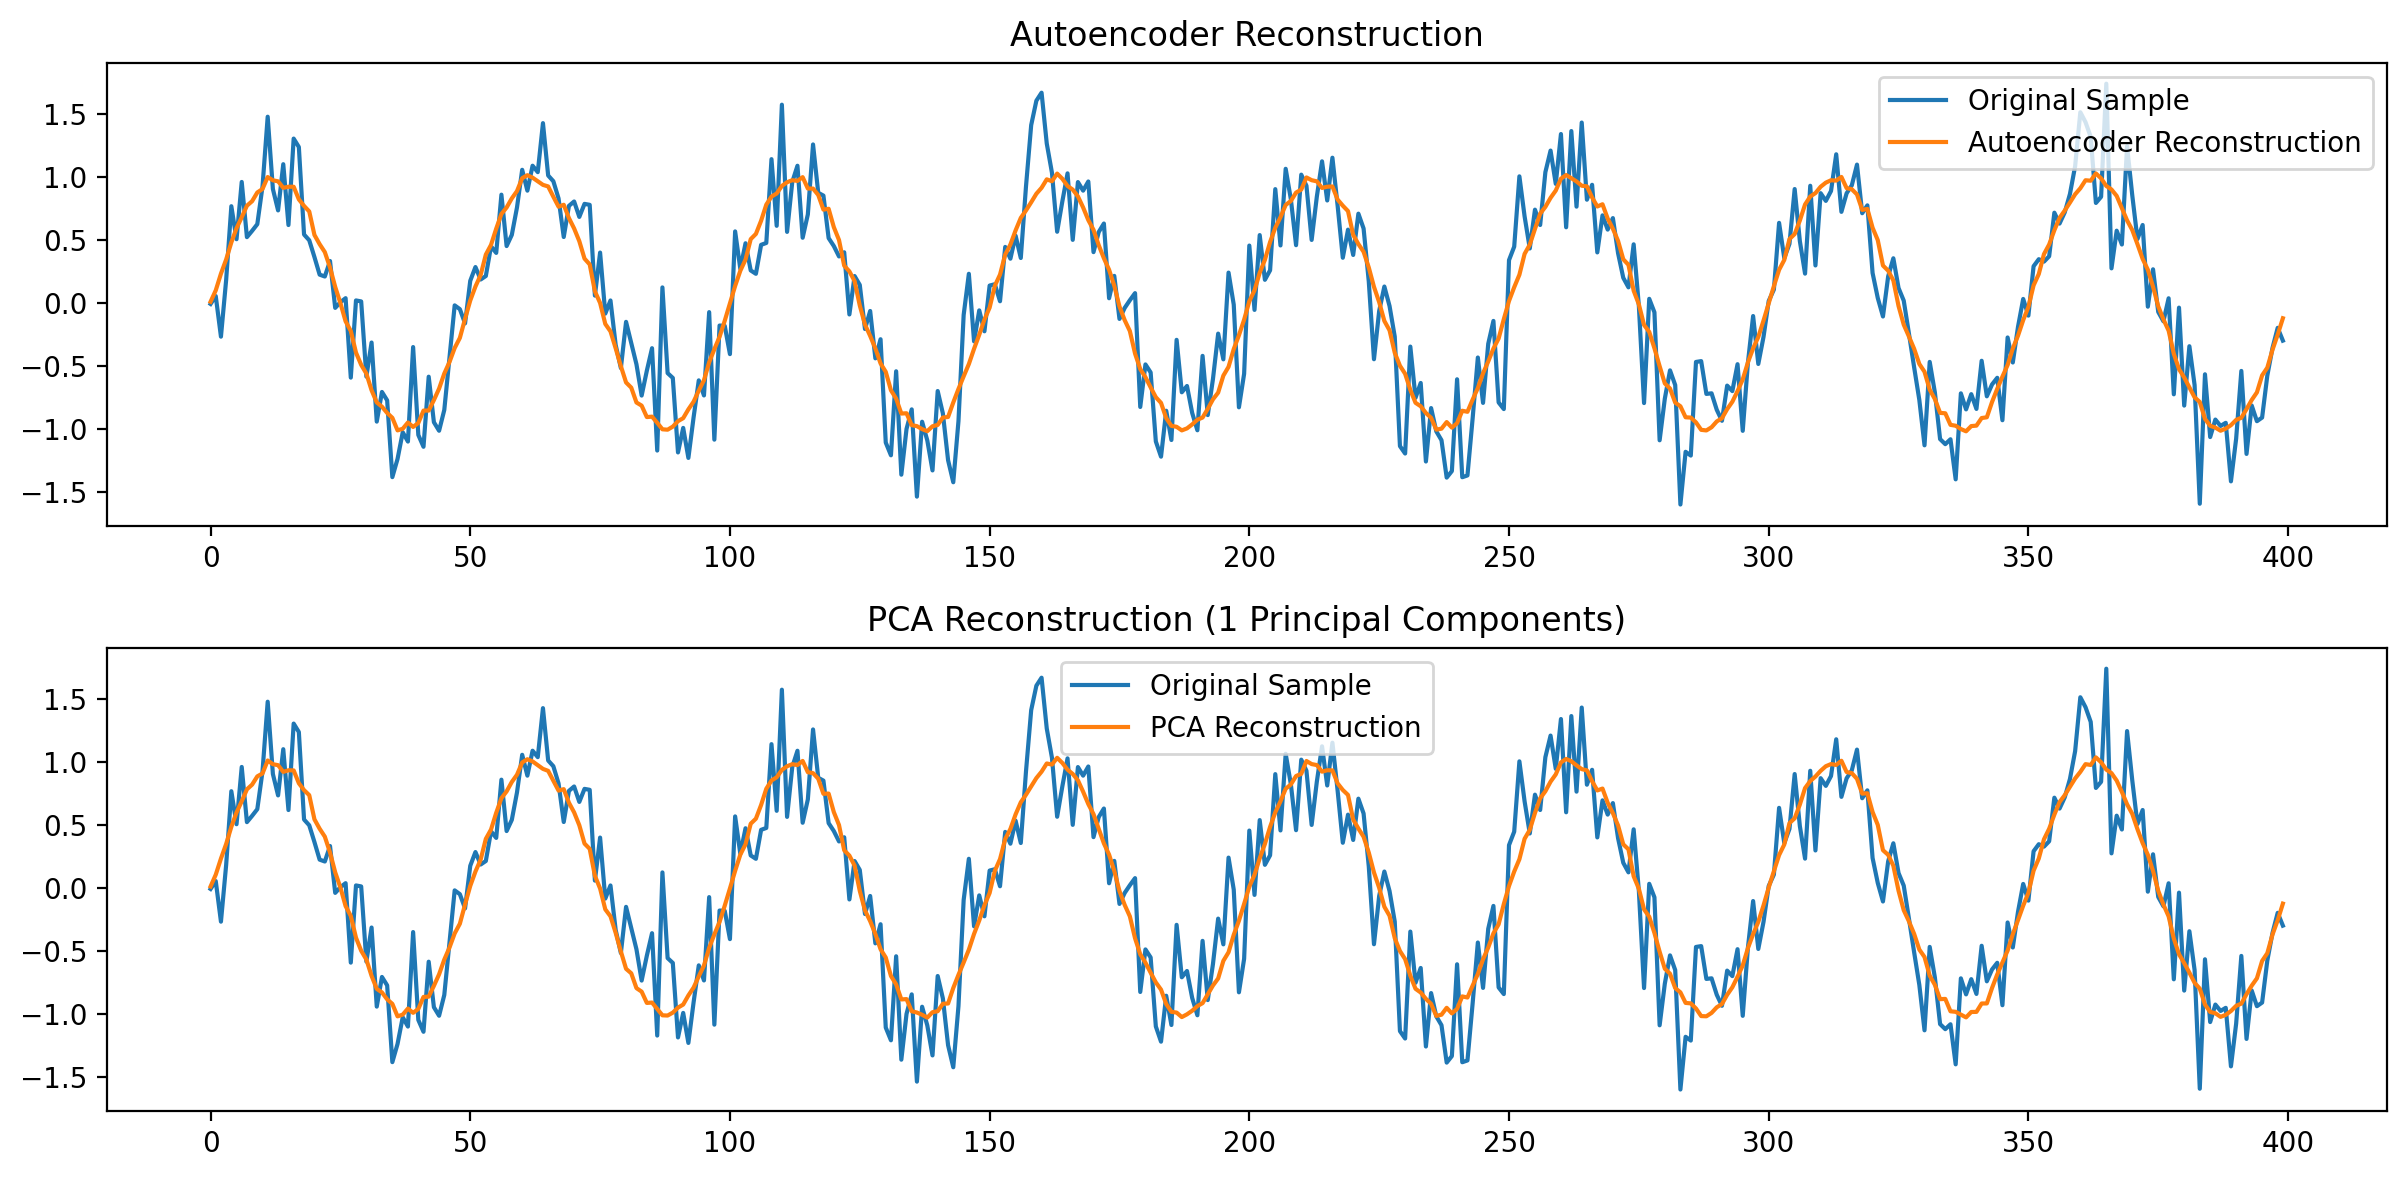

Autoencoder MSE: 0.0931633934378624
PCA MSE: 0.09319628420226117
PCA MSE (1 components): 0.09319628420226117
PCA MSE (2 components): 0.0921344845360911
PCA MSE (3 components): 0.09203278140641537
PCA MSE (4 components): 0.09199292531209165
PCA MSE (5 components): 0.0911592068002319
PCA MSE (6 components): 0.09115105662246553
PCA MSE (7 components): 0.09023840836204645
PCA MSE (8 components): 0.08927012357297505
PCA MSE (9 components): 0.08715513476053992


In [7]:
'''
Your code & plots here.
Please make sure the number of principal components used is clear from your code.
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

# Select a single sample for comparison
sample_index = 0
sample = X_test[sample_index, :].numpy()

# Autoencoder reconstruction
with torch.no_grad():
    hidden = torch.matmul(torch.tensor(sample.reshape(1, -1), dtype=torch.float32), W)
    ae_reconstruction = torch.matmul(hidden, W.T).numpy().flatten()

# PCA reconstruction
pca = PCA(n_components=1) # Use 1 principal components, matching the AE's hidden layer size
pca.fit(xmat.T)  # Fit PCA on the training data (xmat.T)
pca_reconstruction = pca.inverse_transform(pca.transform(sample.reshape(1, -1))).flatten()


# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(sample, label='Original Sample')
plt.plot(ae_reconstruction, label='Autoencoder Reconstruction')
plt.title('Autoencoder Reconstruction')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sample, label='Original Sample')
plt.plot(pca_reconstruction, label='PCA Reconstruction')
plt.title('PCA Reconstruction (1 Principal Components)')
plt.legend()

plt.tight_layout()
plt.show()

#Further analysis (optional) - to compare quantitatively
mse_ae = np.mean((sample - ae_reconstruction)**2)
mse_pca = np.mean((sample - pca_reconstruction)**2)
print(f"Autoencoder MSE: {mse_ae}")
print(f"PCA MSE: {mse_pca}")


# Experiment with different numbers of principal components to find the optimal value

# Example:
for n_components in range(1, 10):
    pca = PCA(n_components=n_components)
    pca.fit(xmat.T)
    pca_rec = pca.inverse_transform(pca.transform(sample.reshape(1,-1))).flatten()
    mse_pca_n = np.mean((sample - pca_rec)**2)
    print(f"PCA MSE ({n_components} components): {mse_pca_n}")

##### Question 8 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.